In [1]:
from collections import defaultdict
import os
import sys
sys.path.append('..')

import pandas as pd
from tqdm import tqdm
import torch
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.nn.util import move_to_device

from adat.utils import load_weights, calculate_wer
from adat.models import get_basic_classification_model, get_basic_seq2seq_model
from adat.dataset import InsuranceReader, OneLangSeq2SeqReader

In [2]:
! nvidia-smi

Sun Jan 12 01:32:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   27C    P8     9W / 280W |   2363MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   28C    P8     8W / 280W |    573MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
max_length = 12
min_length = 2

data = pd.read_csv('../data/full.csv')

data = data[['treatments', 'target']]
treatment_len = data.treatments.apply(lambda x: len(x.split()))
data = data[(treatment_len <= max_length) & (treatment_len >= min_length)]

In [4]:
data['seq_len'] = data.treatments.apply(lambda x: len(x.split()))

negative = data[data.target == 0]
positive = data[data.target == 1]

In [5]:
negative_examples = defaultdict(list)
positive_examples = defaultdict(list)

for row in negative.itertuples():
    negative_examples[row.seq_len].append(row.treatments.strip())
    
for row in positive.itertuples():
    positive_examples[row.seq_len].append(row.treatments.strip())

# Models

In [6]:
seq2seq_reader = OneLangSeq2SeqReader(masker=None)
seq2seq_vocab = Vocabulary.from_files('vocab_seq2seq_masked2')
seq2seq_model = get_basic_seq2seq_model(seq2seq_vocab)
load_weights(seq2seq_model, 'model_seq2seq_masked2.th')

In [7]:
class_reader = InsuranceReader()
class_vocab = Vocabulary.from_files('vocab_classification2')
class_model = get_basic_classification_model(class_vocab)
load_weights(class_model, 'model_classification2.th')

# MCMC example

In [8]:
from adat.mcmc import MCMCSampler, NormalProposal, RandomSampler
from pprint import pprint

In [9]:
example = positive_examples[10][1]
print(example)

a_549 a_574 a_1979 a_1978 a_663 a_1849 a_623 a_621 a_622 a_600


In [10]:
proposal = NormalProposal(variance=0.01)
sampler = MCMCSampler(
    proposal_distribution=proposal, 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    sigma_prob=1.0,
    sigma_bleu=2.0
)

sampler.set_input(initial_sequence=example)

In [11]:
print(f'Probability = {sampler.curr_prob}\nBleu = {sampler.curr_bleu}')

Probability = 0.736770749092102
Bleu = 0.8366600265340756


In [12]:
history = sampler.sample(num_steps=100)

In [13]:
last_sampled = history[-1]

print(f"""Initial seq = {example}\nSampled seq = {last_sampled['generated_sequence']}
      \nNew prob = {last_sampled['prob']}\nNew bleu = {last_sampled['bleu']}""")

Initial seq = a_549 a_574 a_1979 a_1978 a_663 a_1849 a_623 a_621 a_622 a_600
Sampled seq = a_574 a_1979 a_1978 a_663 a_1849 a_2031 a_621 a_663 a_1984
      
New prob = 0.3668229281902313
New bleu = 0.5166357204442371


In [14]:
%timeit sampler.set_input(initial_sequence=example)

28.6 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MCMC search

In [15]:
from tqdm import tqdm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
def sample_search(sampler, data, num_steps=200, burn_steps=30):
    output = []
    for seq_len, examples in data.items():
        for example in tqdm(examples):
            sampler.set_input(example)
            prob = sampler.curr_prob
            bleu = sampler.curr_bleu

            history = sampler.sample(num_steps=num_steps)

            for ex in history[burn_steps:]:
                ex['original'] = example
                ex['prob_diff'] = ex['prob'] - prob
                ex['bleu_diff'] = ex['bleu'] - bleu
                ex['seq_len'] = seq_len
                output.append(ex)
            sampler.empty_history()
    return pd.DataFrame(output)

In [ ]:
mcmc_sampler = MCMCSampler(
    proposal_distribution=NormalProposal(0.01), 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    sigma_prob=1.0,
    sigma_bleu=2.0,
    device=3
)

mcmc_output = sample_search(mcmc_sampler, positive_examples)

  0%|          | 1/338 [00:02<12:49,  2.28s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 4/338 [00:09<13:19,  2.39s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order 

  4%|▍         | 14/338 [00:33<12:40,  2.35s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

 14%|█▎        | 46/338 [01:48<11:31,  2.37s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

 15%|█▌        | 52/338 [02:02<11:27,  2.40s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

 34%|███▎      | 114/338 [04:29<08:55,  2.39s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram orde

 34%|███▍      | 115/338 [04:31<08:20,  2.24s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 35%|███▌      | 119/338 [04:41<08:45,  2.40s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower or

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [30]:
mcmc_output.shape

(424486, 10)

In [33]:
(mcmc_output.bleu_diff > 0).mean()

0.039600834892081244

In [59]:
for idx, row in mcmc_output[(mcmc_output.bleu_diff >= -0.2) & (mcmc_output.prob_diff <= -0.3)].sample(10).iterrows():
    print(f"Original = {row['original']}\nGenerated = {row['generated_sequence']}\n")

Original = a_723 a_1858 a_1885 a_1860 a_1860 a_2001 a_645 a_1861 a_1656
Generated = a_723 a_1858 a_1885 a_1860 a_2001 a_645 a_1861 a_1656

Original = a_314 a_645 a_642 a_1656 a_2001 a_1647 a_817 a_271 a_1737
Generated = a_756 a_645 a_642 a_1656 a_2001 a_1647 a_817 a_271 a_1737

Original = a_768 a_1 a_2032 a_774 a_1979 a_1656 a_885 a_740
Generated = a_768 a_1 a_2032 a_774 a_852 a_1656 a_885 a_740

Original = a_1656 a_561 a_1 a_1444 a_1649 a_405 a_376 a_353 a_2001 a_354 a_411
Generated = a_1431 a_1656 a_1 a_1444 a_1649 a_2157 a_2030 a_1639 a_2001 a_354 a_520

Original = a_1444 a_1650 a_660 a_1978 a_1890 a_574 a_1946 a_600 a_550 a_1979 a_362 a_1
Generated = a_1444 a_1650 a_1978 a_1890 a_574 a_1946 a_600 a_550 a_1979 a_362 a_1

Original = a_81 a_153 a_1419 a_1410 a_1 a_82 a_93 a_93 a_1437
Generated = a_81 a_2085 a_1419 a_1410 a_1 a_82 a_93 a_93 a_1437

Original = a_1627 a_1461 a_1936 a_1462 a_1 a_1890 a_574 a_1534 a_600 a_1978
Generated = a_2018 a_1461 a_1936 a_1462 a_1 a_1890 a_574 a_1534

In [48]:
mcmc_output.head()

,acceptance_probability,bleu,bleu_diff,generated_sequence,original,previous_bleu_diff,previous_prob_diff,prob,prob_diff,seq_len
0,0.990128,1.000000,0.000000,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,0.000000,0.000000,0.009922,0.000000,7
1,0.871997,0.757116,-0.242884,a_645 a_1978 a_1 a_1257 a_1191 a_2001,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,-0.242884,0.005606,0.015527,0.005606,7
2,0.871997,0.757116,-0.242884,a_645 a_1978 a_1 a_1257 a_1191 a_2001,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,0.000000,0.000000,0.015527,0.005606,7
3,0.871997,0.757116,-0.242884,a_645 a_1978 a_1 a_1257 a_1191 a_2001,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,0.000000,0.000000,0.015527,0.005606,7
4,0.871997,0.757116,-0.242884,a_645 a_1978 a_1 a_1257 a_1191 a_2001,a_645 a_1978 a_362 a_1 a_1257 a_1191 a_2001,0.000000,0.000000,0.015527,0.005606,7


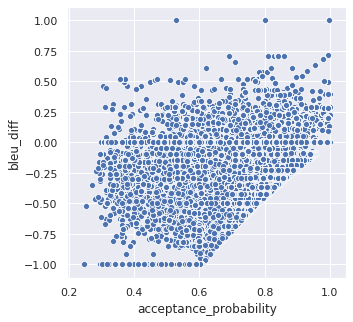

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="acceptance_probability", y="bleu_diff", data=mcmc_output, ax=ax)

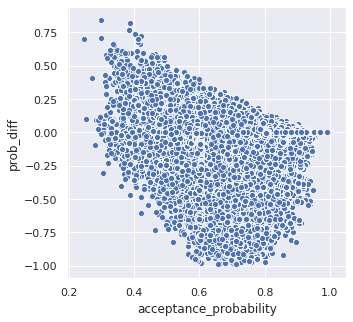

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="acceptance_probability", y="prob_diff", data=mcmc_output, ax=ax)

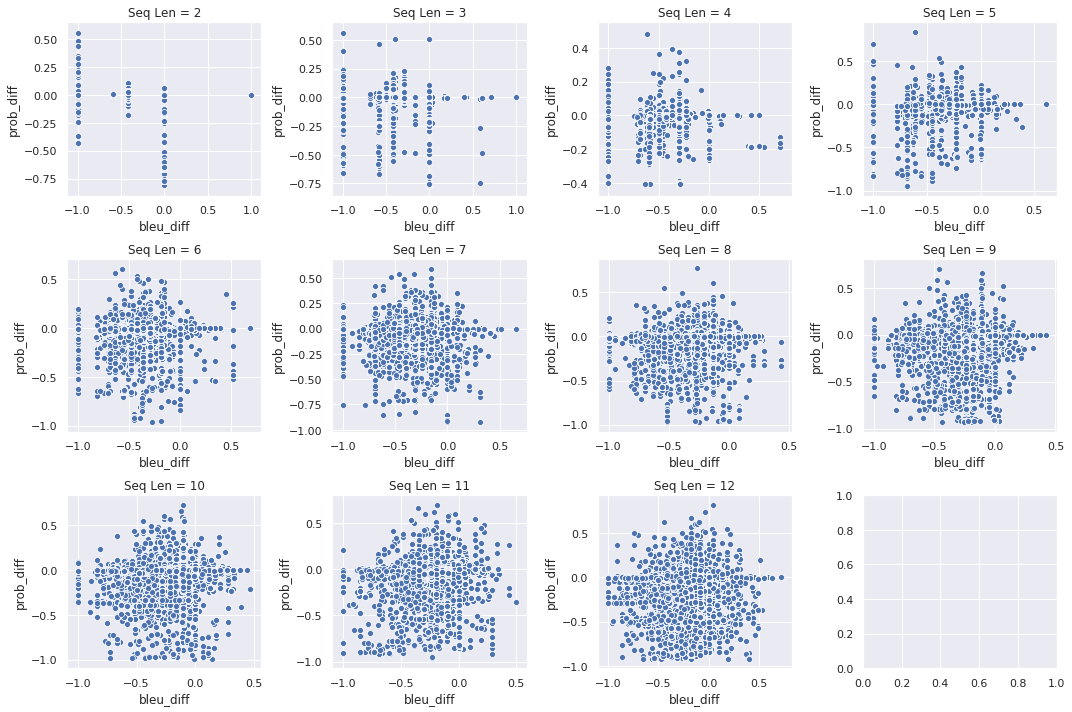

In [25]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for seq_len in range(min_length, max_length + 1):
    curr_data = mcmc_output[mcmc_output.seq_len == seq_len][['prob_diff', 'bleu_diff']]
    axes[int((seq_len - 2) / 4), (seq_len - 2) % 4].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 4), (seq_len - 2) % 4])
    
fig.tight_layout()

## Random Sampler

In [ ]:
random_sampler = RandomSampler(
    proposal_distribution=NormalProposal(0.01), 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    device=3
)

random_output = sample_search(random_sampler, positive_examples)

In [29]:
random_output.shape

(543150, 7)

In [32]:
(random_output.bleu_diff > 0).mean()

0.01914020068121145

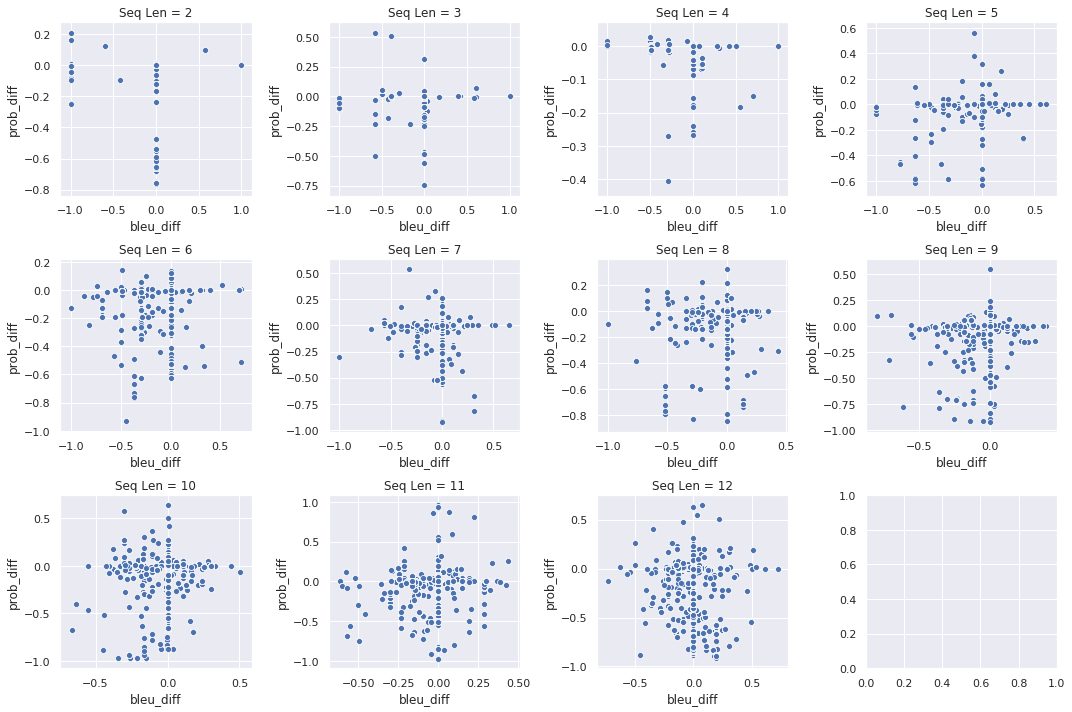

In [28]:
# positive examples

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for seq_len in range(min_length, max_length + 1):
    curr_data = random_output[random_output.seq_len == seq_len][['prob_diff', 'bleu_diff']]
    axes[int((seq_len - 2) / 4), (seq_len - 2) % 4].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 4), (seq_len - 2) % 4])
    
fig.tight_layout()

## Random Sampler, Var = 0.05

In [ ]:
random_sampler2 = RandomSampler(
    proposal_distribution=NormalProposal(0.05), 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    device=3
)

random_output2 = sample_search(random_sampler2, positive_examples)

In [ ]:
# positive examples

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for seq_len in range(min_length, max_length + 1):
    curr_data = random_output2[random_output2.seq_len == seq_len][['prob_diff', 'bleu_diff']]
    axes[int((seq_len - 2) / 4), (seq_len - 2) % 4].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 4), (seq_len - 2) % 4])
    
fig.tight_layout()

## Random Sampler, Var = 0.1

In [ ]:
random_sampler3 = RandomSampler(
    proposal_distribution=NormalProposal(0.1), 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    device=3
)

random_output3 = sample_search(random_sampler3, positive_examples)

In [ ]:
# positive examples

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for seq_len in range(min_length, max_length + 1):
    curr_data = random_output3[random_output3.seq_len == seq_len][['prob_diff', 'bleu_diff']]
    axes[int((seq_len - 2) / 4), (seq_len - 2) % 4].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 4), (seq_len - 2) % 4])
    
fig.tight_layout()

In [ ]:
1